In [2]:
reset


Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [5]:
import glob
import os
import numpy as np
import scipy.io as spio

from keras.models import Model
from keras.models import Model
from keras.applications.resnet50 import ResNet50
from keras.preprocessing import image
from keras.applications.resnet50 import preprocess_input

from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score
from collections import Counter
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn import preprocessing

from scipy.signal import savgol_filter

from matplotlib.pyplot import imshow
import numpy as np
from PIL import Image




path = '../features/biDir_LSTM128128_D6464.features.npy'
preds = np.load(path)


In [6]:
def readMat(dataPath):
    
    
    #readMat: Reads the .mat for mad river data files placed at data path
    #INPUT
    #dataPath == relative location of the data path to the code file, or absolute
    #
    #OUTPUT
    #still being worked on
    #eventToClass== np array of all classes belonging to all 616events. value at 0 index is class for 0th event.
    #sedimentData_events == list containing array for sediment data for each event
    #
    #
    #events == list containing 2-D array for each event. 1st column is sediment and 2nd is stream flow. Ideally we will be using this
    #maxEventLen == Longest event in terms of timesteps
    
    #sample call: eventToClass, myEvents, maxEventLen,streamFlow_Data,sedimentData_events = readMat('..\data\')
    
    #Programmer: Ali Javed
    #Date last modified: 27 Feb 2018
    #modified by: Ali Javed
    #Comments: Initial version.
    
    
    ##############################################################################################################
        
    
    
    
    classMat = spio.loadmat(dataPath + 'allMadSitesStormHystClassKey.mat', squeeze_me=True)
    dataMat = spio.loadmat(dataPath + 'allMadSitesEventTimeSeries.mat', squeeze_me=True)
    
    eventToClass = classMat['stormHystClass'][:,3] #index 3 refers to class of 3rd event. Event number start from 0
    eventToClass = eventToClass.astype(int) # we do not need float classes




    #gather 626 events
    events = []
    sedimentData_events = []
    streamFlowData_events = []
    counter = 0
    maxEventLen = -1 #need this as fixed size input to keras RNN
    
    streamFlow = 1
    suspendedSedimentConcentration = 2
    
    for event in range(0,len(dataMat['dataTSOut'])):
    
    
        #not reading datetime and rainfall data for now
        #event_dataTime = np.zeros((len(dataMat['dataTSOut'][event][streamFlow]))) #can not extract datetime so setting it to one, for out purpose it does not matter anyways
        #event_rainFall = np.zeros((len(dataMat['dataTSOut'][event][streamFlow])))
                             
        event_streamflow = dataMat['dataTSOut'][event][streamFlow]
        event_suspendedSedimentConcentration = dataMat['dataTSOut'][event][suspendedSedimentConcentration]
    
        
        eventArray = np.column_stack((event_streamflow,event_suspendedSedimentConcentration))
        
        
        events.append(eventArray)
        sedimentData_events.append(event_streamflow)
        streamFlowData_events.append(event_suspendedSedimentConcentration)
    
        if len(event_streamflow)> maxEventLen:
            maxEventLen = len(event_streamflow)
    
    
        
        ##############################################################################################################
        #for classification based only on rain and sediment... i can not figure out how to give 2d input to RNN
        
        
        #classVector = np.repeat(eventToClass[event], len(event_streamflow))
        #print(np.shape(classVector))
        #print(np.shape(suspendedSedimentConcentration))
        #streamFlow_Data = np.column_stack((event_streamflow,classVector))
        #suspendedSedimentConcentration_Data = np.column_stack((event_suspendedSedimentConcentration,classVector))
        
    return eventToClass, events, maxEventLen, streamFlowData_events, sedimentData_events
    
    
 ##############################################################################################################
       

 



In [7]:
dataPath = '../data/'

eventToClass, myEvents, maxEventLen,streamFlow_Data,sedimentData_events = readMat(dataPath)



rain_sediment = []
for i in range(0,len(sedimentData_events)):    
    t1 = sedimentData_events[i]
    t2 = streamFlow_Data[i]
    t1 = preprocessing.scale(t1)
    t2 = preprocessing.scale(t2)
    
    
    rain_sediment_event = np.column_stack((t1,t2))
    rain_sediment.append(rain_sediment_event)
    



In [8]:
X_data = rain_sediment
for i in range(0,len(X_data)):
    X_data[i] = preprocessing.normalize(X_data[i])

In [9]:
np.shape(preds)

(626, 64)

In [10]:
inertia = []
for i in range(1,35):
    kmeans = KMeans(n_clusters=i, random_state=0).fit(preds)
    inertia.append(kmeans.inertia_)

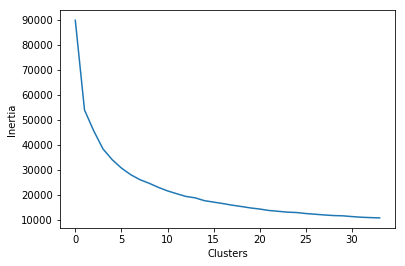

In [11]:
import matplotlib.pyplot as plt
plt.plot(inertia)
plt.ylabel('Inertia')
plt.xlabel('Clusters')

plt.show()

We chose six classes as elbow point primarly because elbow point is definitely plus minue 1 and having 5 matches the partent ground truth of our groud truth (refer to back groud slides).

In [12]:
kmeans = KMeans(n_clusters=6, random_state=0, max_iter = 600).fit(preds)

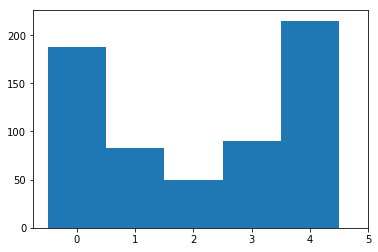

In [13]:
d = kmeans.labels_
fig, ax = plt.subplots(1,1)
bins = np.arange(d.min(), d.max()+1)
plt.hist(d, bins=bins,align='left')
ax.set_xticks(bins)
plt.show() 



In [14]:
clusterCenters = kmeans.cluster_centers_ 
clusterLabels = kmeans.labels_

Find coordinates of cluster centers and plot them

In [15]:
dists = kmeans.transform(preds)

In [16]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics.pairwise import euclidean_distances
e = euclidean_distances(clusterCenters,preds )
s = cosine_similarity(clusterCenters,preds )
s.argmin(axis=1)


array([ 50, 381, 489,  43, 613, 122])

In [17]:
centers = s.argmin(axis=1)
centers

array([ 50, 381, 489,  43, 613, 122])

In [18]:
def returndata(event_num):
    #event_num = 526
    y = sedimentData_events[event_num]
    z = streamFlow_Data[event_num]
    x = np.arange(0,len(sedimentData_events[event_num]))
    label = clusterLabels[event_num]
    
    return x,y,z


def displayHysteresis(dataPath,imgNum,rowsize):
    imageMat = spio.loadmat(dataPath + 'allMadSitesGrayscale28x28StormImages.mat', squeeze_me=True)
    images = imageMat['Grayscale28x28']
    
    fig = plt.figure(figsize=(18,2))
    for i in range(0,rowsize):
        event_num = imgNum[i]
        axarr= fig.add_subplot(1, rowsize, i+1)
        image = images[event_num]
        #image = np.reshape(image, (784))
        image = np.reshape(image,(28,28))
        #image = np.rot90(image)
        #image = np.rot90(image)
        axarr.axis([0, 28, 0, 28])
        axarr.imshow(image)
        
        
    
    
def createHysteresis(events, windowsize, ployorder, rowsize):    
    rowsize = len(events)
    #fig = plt.figure(figsize=plt.figaspect(0.5))
    fig = plt.figure(figsize=(18,2))
    for i in range(0,rowsize):
        event_num = events[i]
        #projection='3d'
        axarr= fig.add_subplot(1, rowsize, i+1)
        x,y,z = returndata(event_num)
        x = savgol_filter(x, windowsize, polyorder)
        x = (x - min(x))/ (max(x) - min(x))
        y = (y - min(y))/ (max(y) - min(y))
        
        
        axarr.plot(y,z)
        axarr.set_title('Event Num= '+str(event_num) + ' GT = ' + str(eventToClass[event_num]))

    plt.show()

    
    
    
    

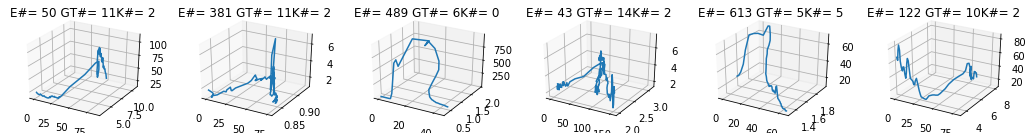

/Users/alijaved/anaconda/lib/python3.6/site-packages/scipy/linalg/basic.py:1226: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


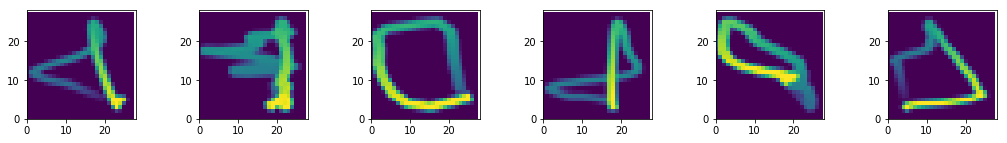

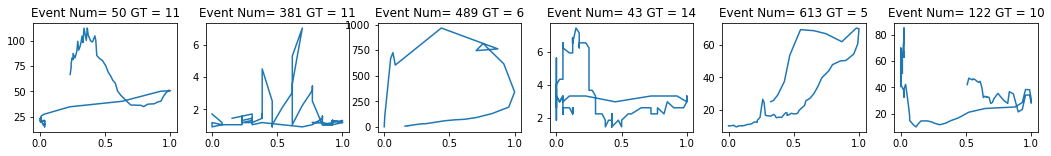

In [19]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


rowsize = len(centers)
windowsize = 11
polyorder = 4
#fig = plt.figure(figsize=plt.figaspect(0.5))
fig = plt.figure(figsize=(18,2))
for i in range(0,rowsize):
    event_num = centers[i]
    axarr= fig.add_subplot(1, rowsize, i+1, projection='3d')
    x,y,z = returndata(event_num)
    axarr.plot(x,y,z)
    axarr.set_title('E#= '+str(event_num) + ' GT#= ' + str(eventToClass[event_num]) + 'K#= ' + str(clusterLabels[event_num]))


plt.show()

displayHysteresis(dataPath,centers,rowsize)
createHysteresis(centers, windowsize, polyorder, rowsize)
plt.show()


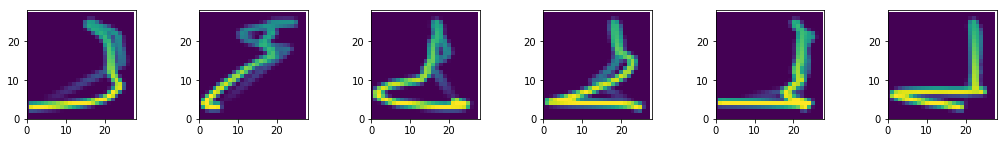

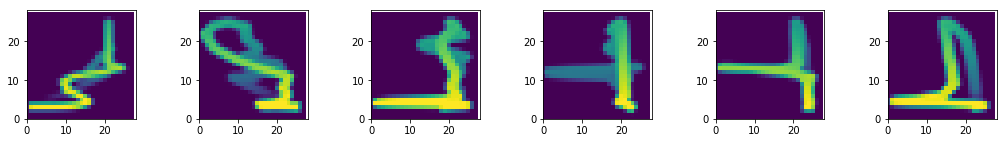

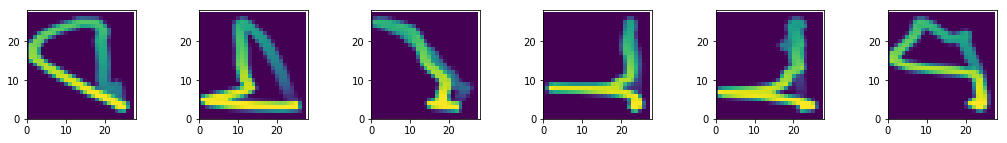

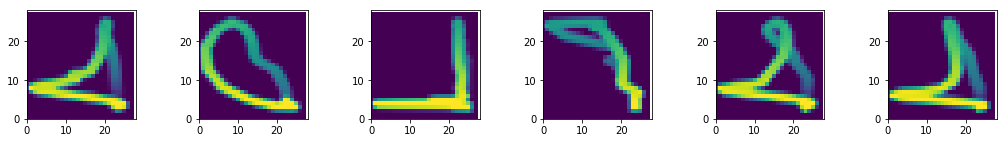

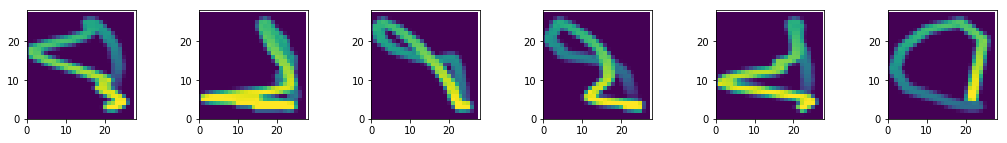

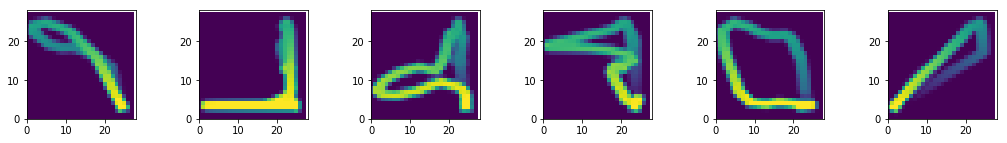

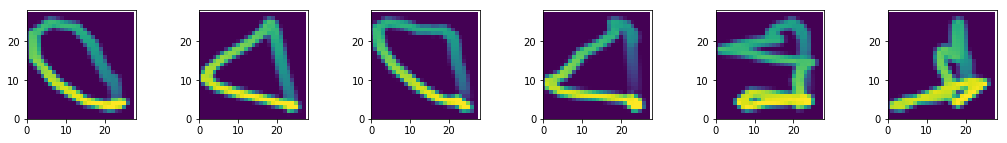

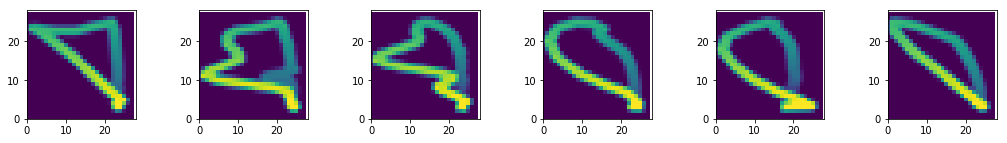

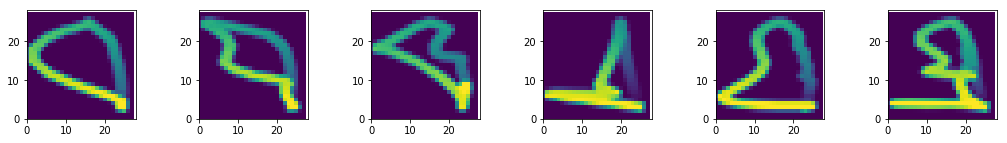

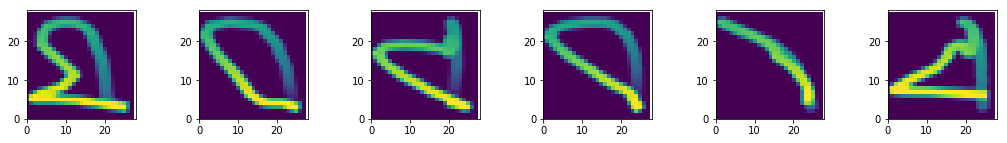

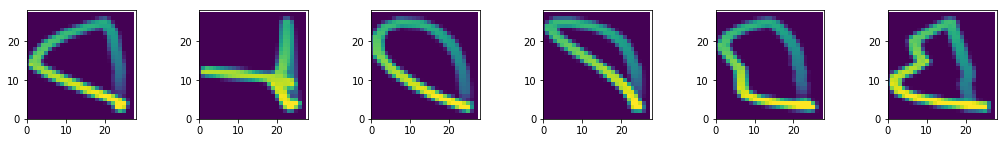

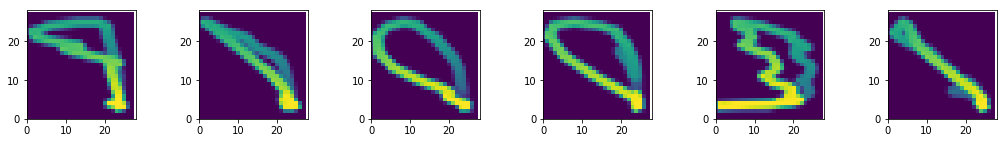

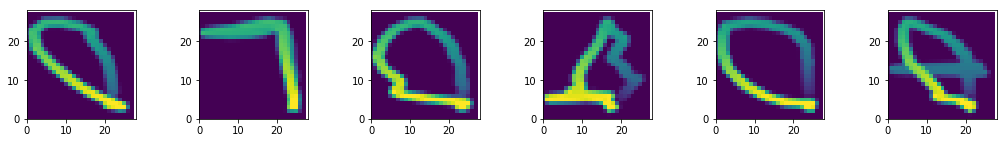

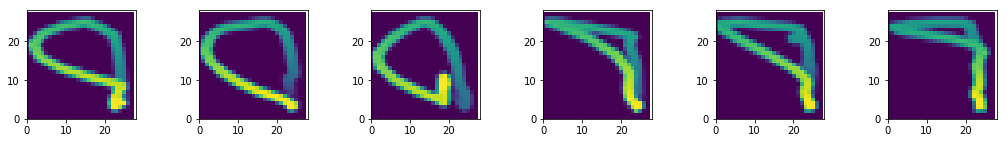

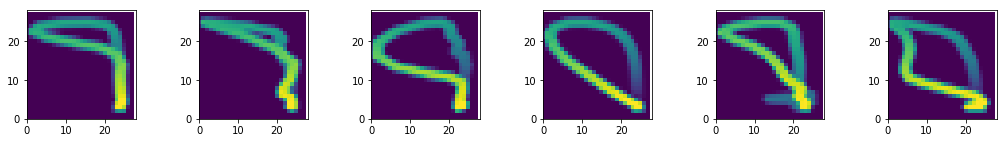

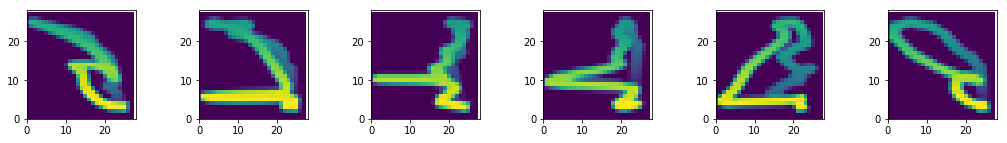

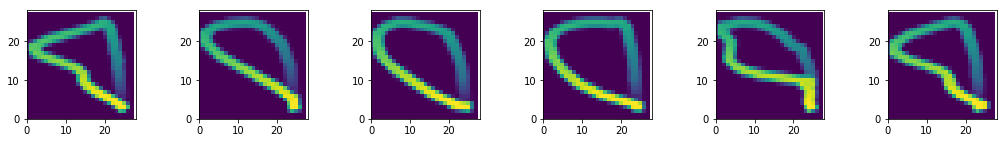

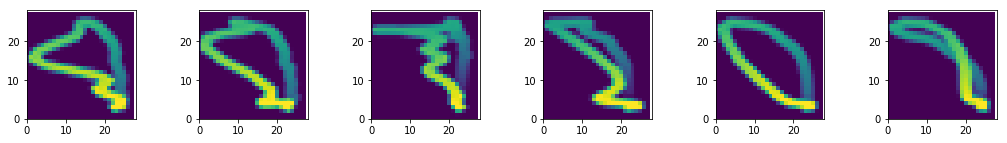

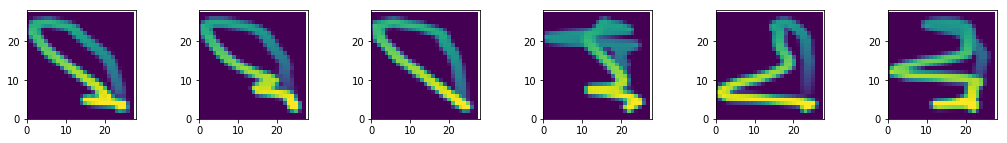

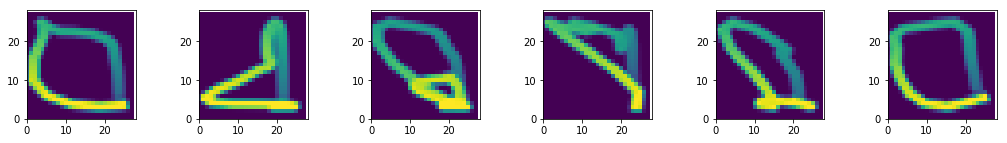

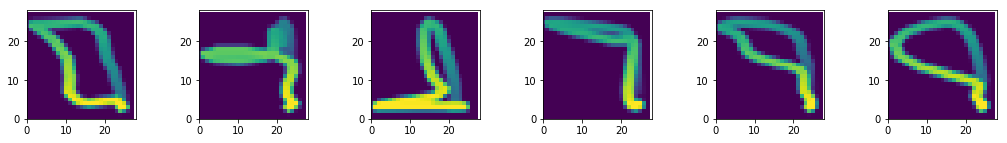

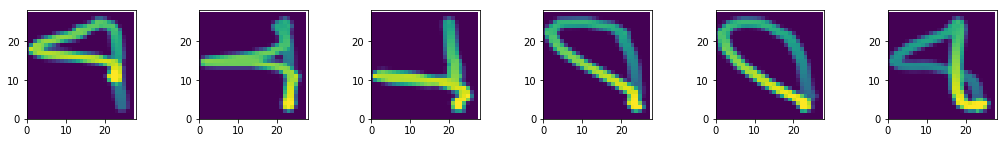

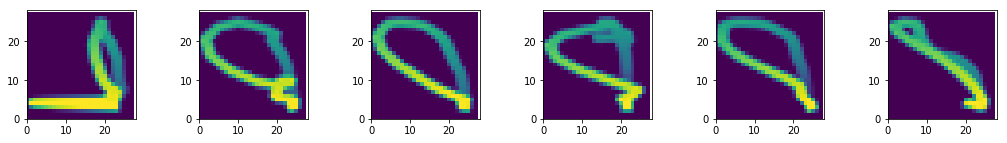

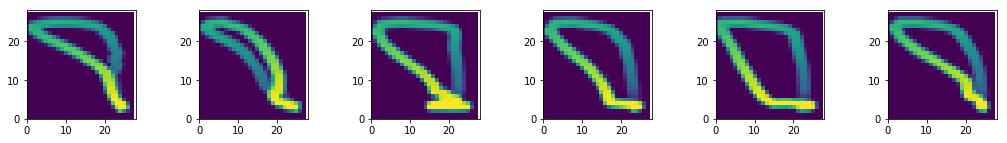

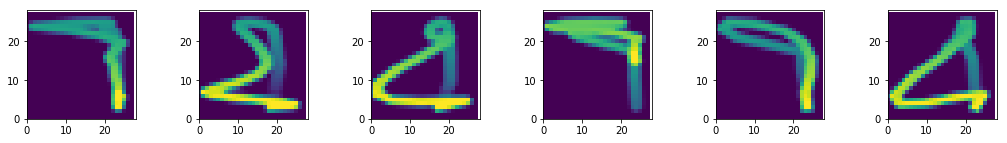

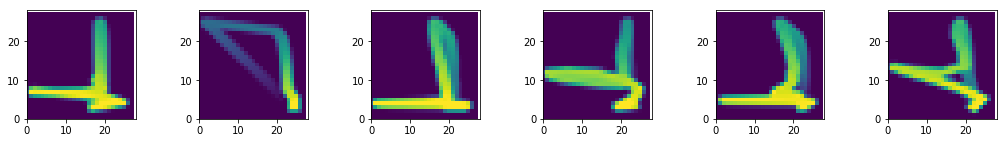

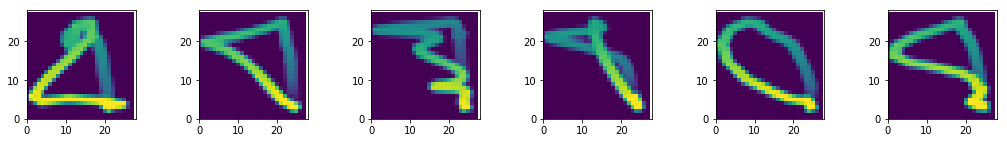

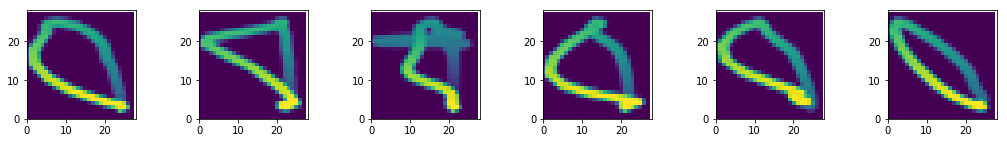

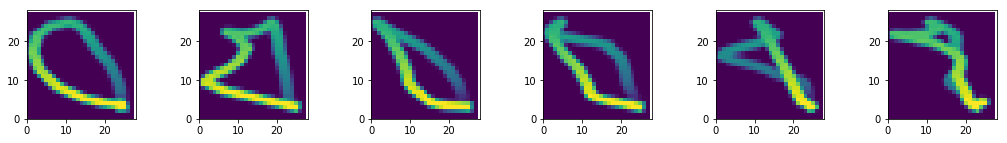

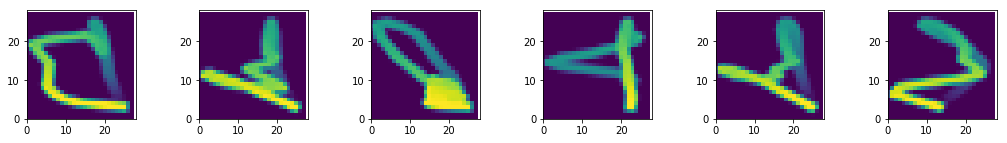

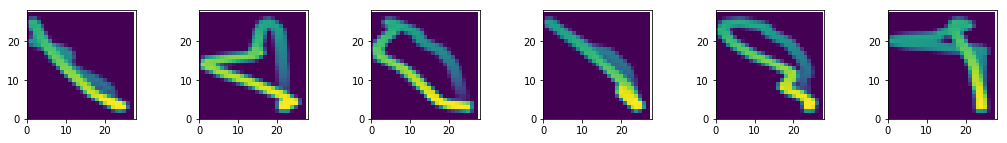

In [20]:
counter = 0
plot = []
rowsize = 6
plotCluster = 0
windowsize = 11
polyorder = 4
for label in clusterLabels:
    
    if label == plotCluster:
        plot.append(counter)
    
    if (len(plot)% rowsize ==0) and (len(plot)>0):
        displayHysteresis(dataPath,plot,rowsize)
          
        plt.show()
        plot = []
    counter = counter+1    
        
        


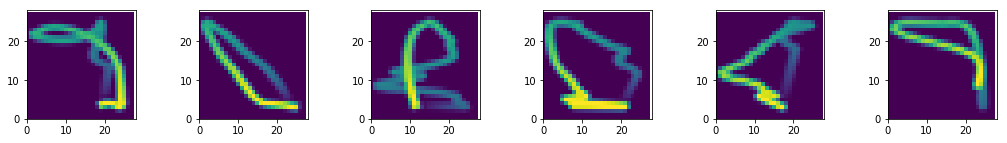

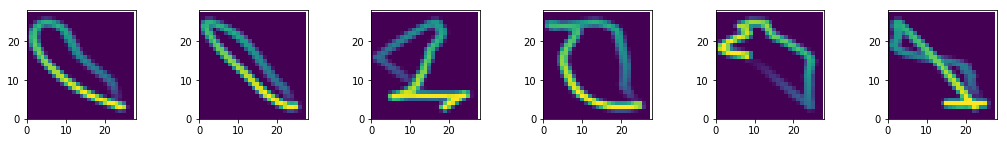

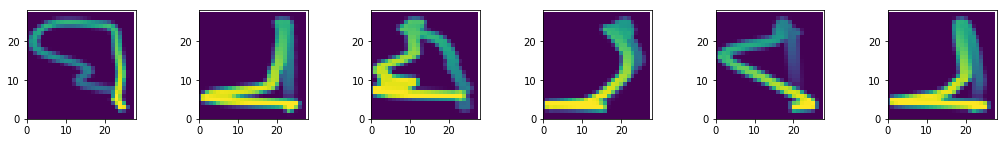

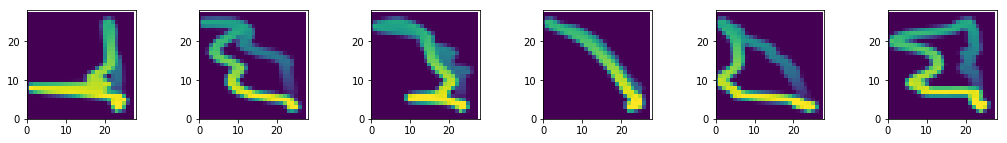

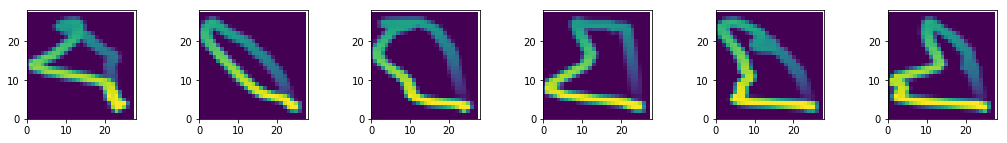

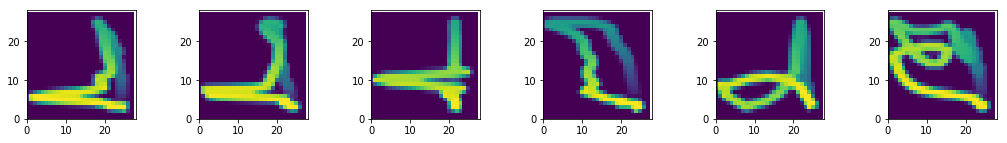

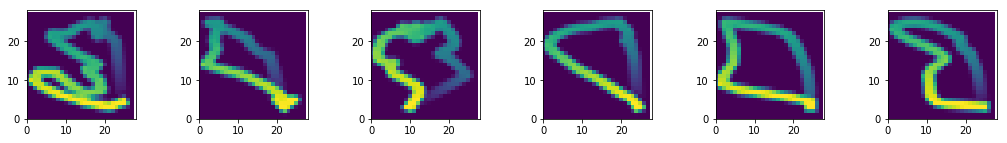

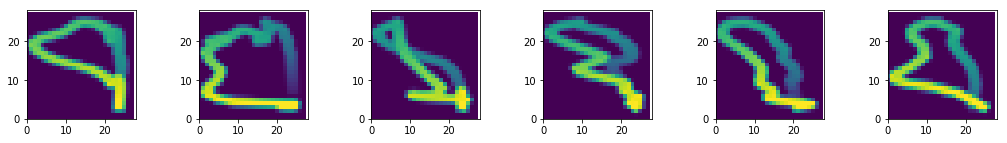

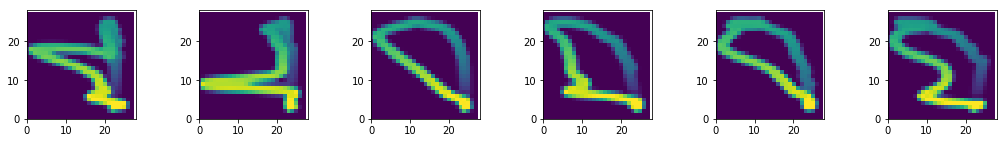

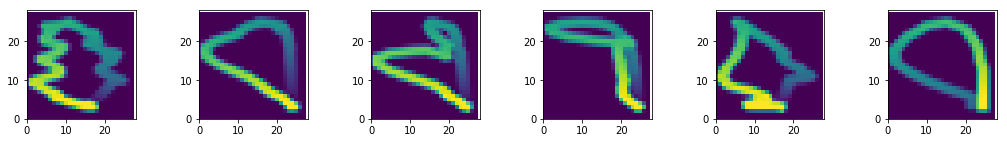

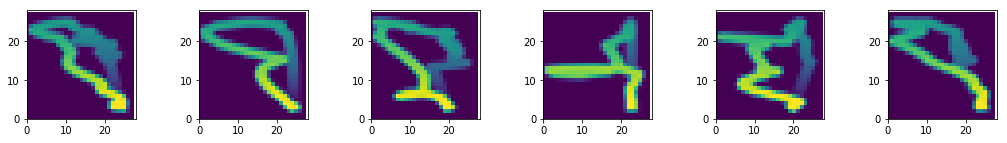

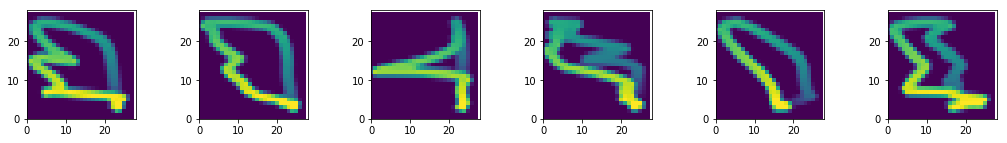

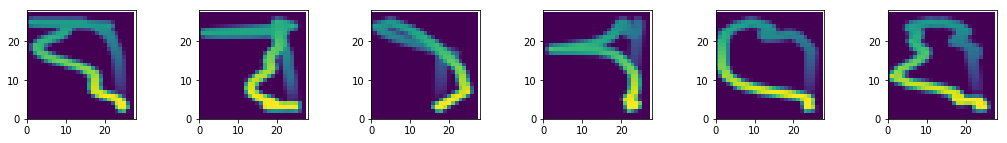

In [21]:
counter = 0
plot = []
rowsize = 6
plotCluster = 1
for label in clusterLabels:
    
    if label == plotCluster:
        plot.append(counter)
    
    if (len(plot)% rowsize ==0) and (len(plot)>0):
        displayHysteresis(dataPath,plot,rowsize)
        plt.show()
        plot = []
    counter = counter+1    

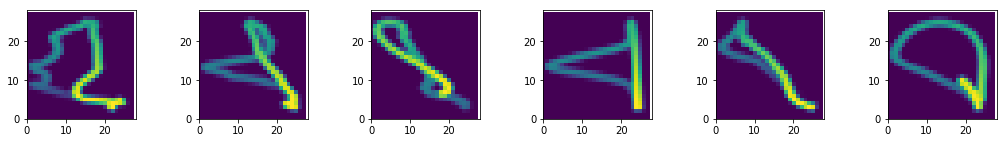

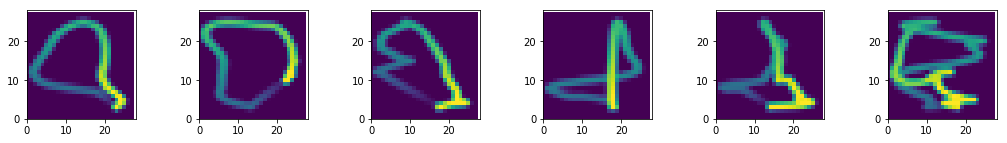

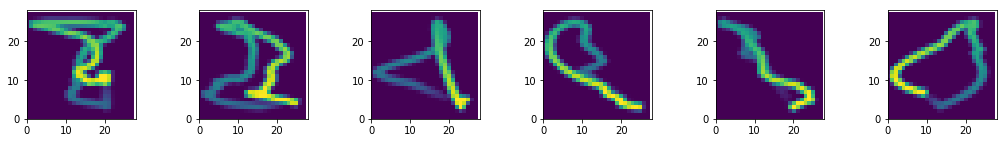

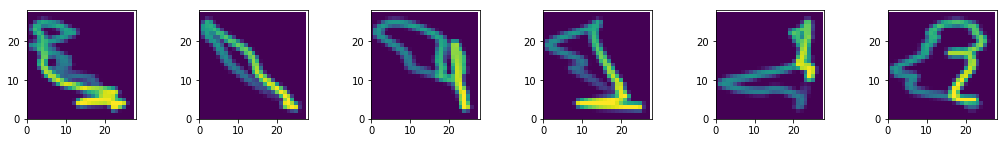

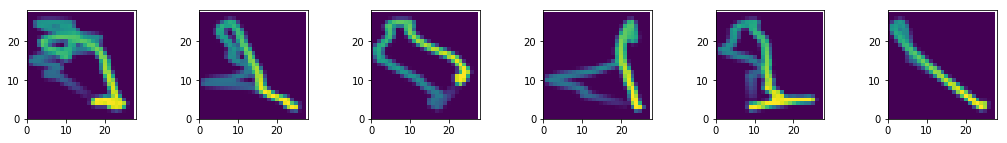

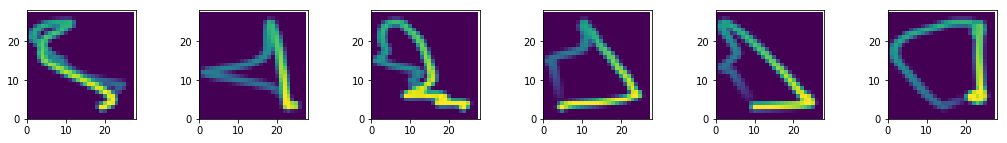

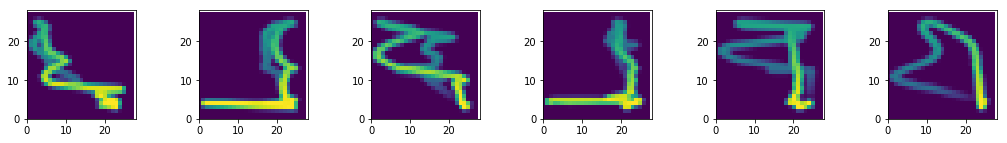

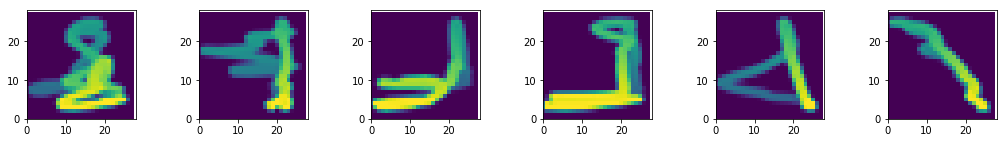

In [22]:
counter = 0
plot = []
rowsize = 6
plotCluster = 2
for label in clusterLabels:
    
    if label == plotCluster:
        plot.append(counter)
    
    if (len(plot)% rowsize ==0) and (len(plot)>0):
        displayHysteresis(dataPath,plot,rowsize)
        plt.show()
        plot = []
    counter = counter+1    

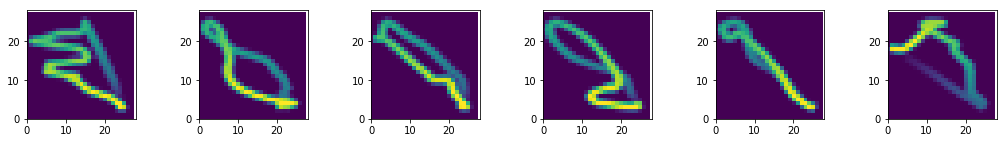

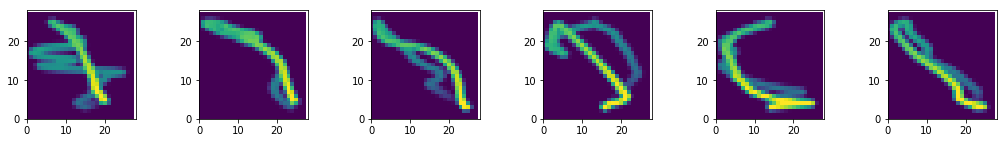

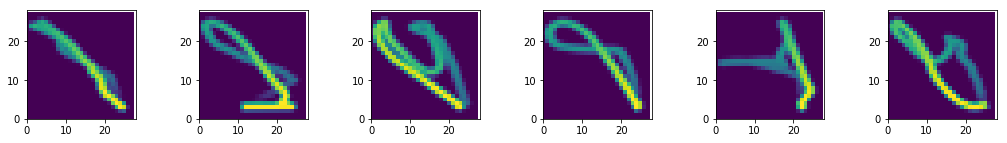

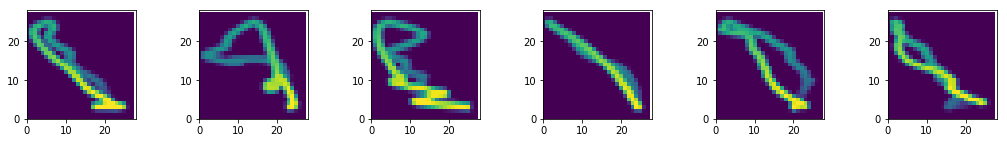

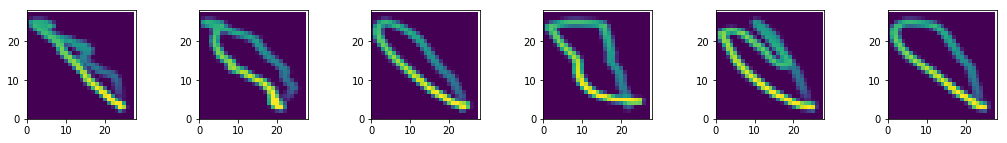

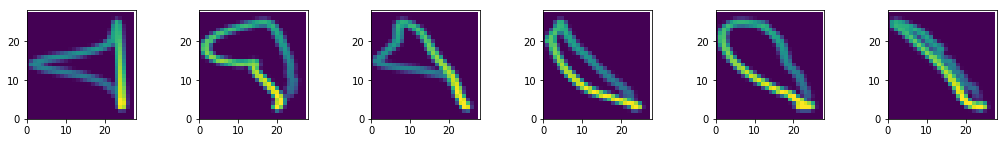

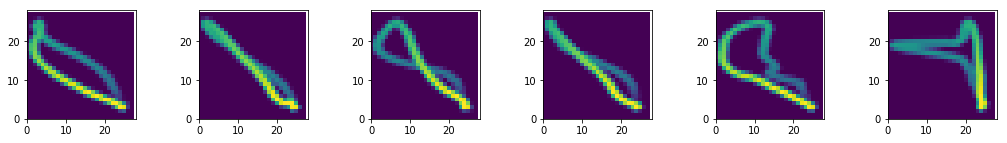

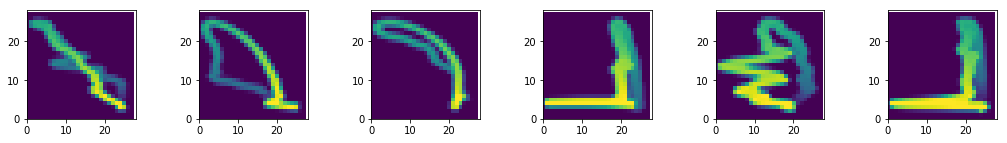

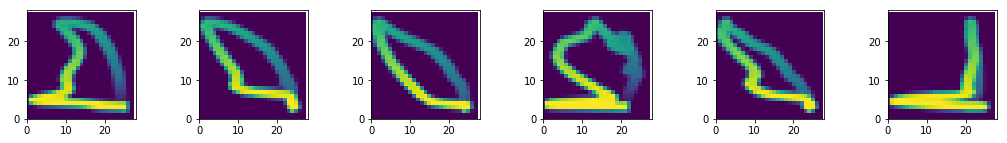

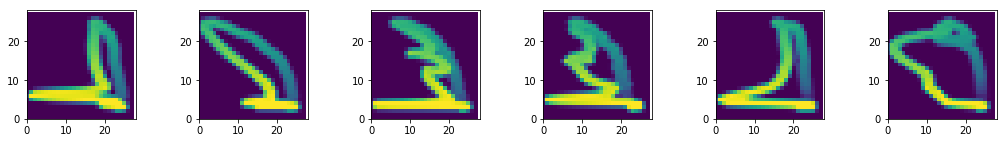

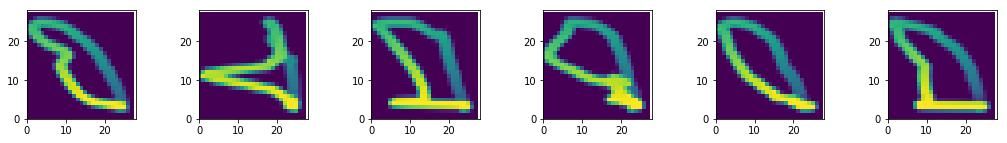

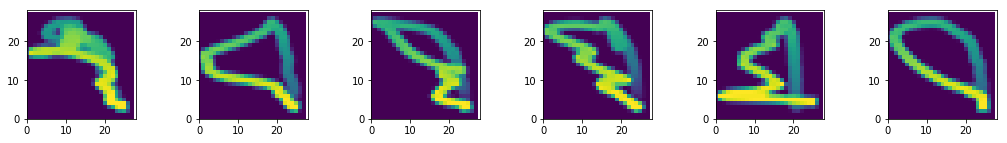

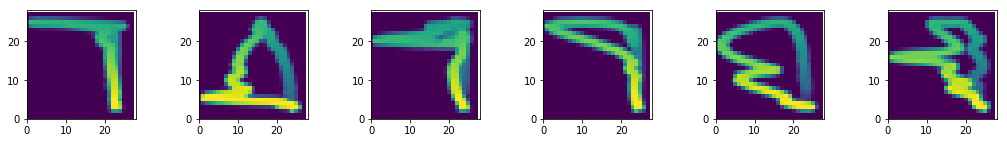

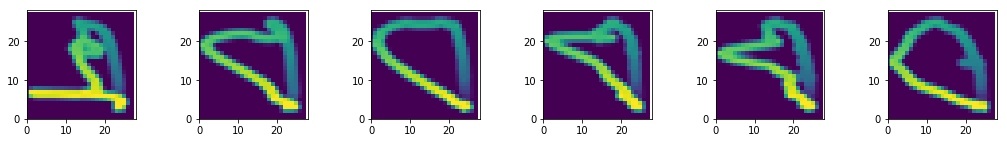

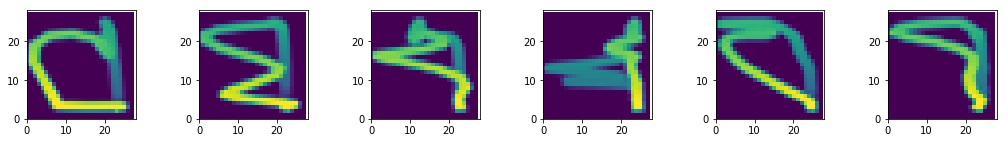

In [23]:
counter = 0
plot = []
rowsize = 6
plotCluster = 3
for label in clusterLabels:
    
    if label == plotCluster:
        plot.append(counter)
    
    if (len(plot)% rowsize ==0) and (len(plot)>0):
        displayHysteresis(dataPath,plot,rowsize)
        plt.show()
        plot = []
    counter = counter+1    

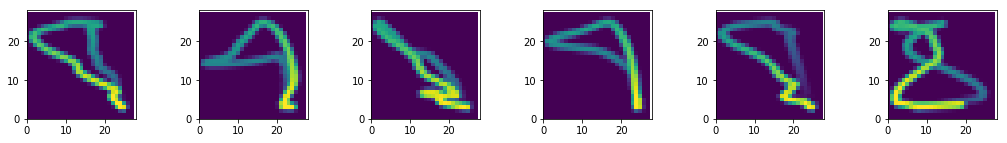

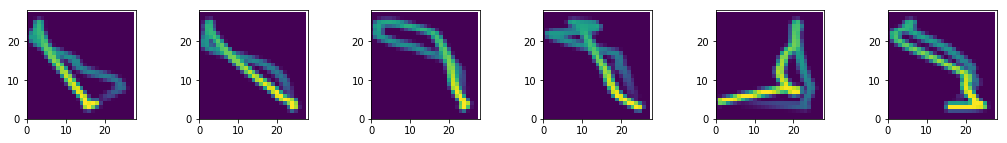

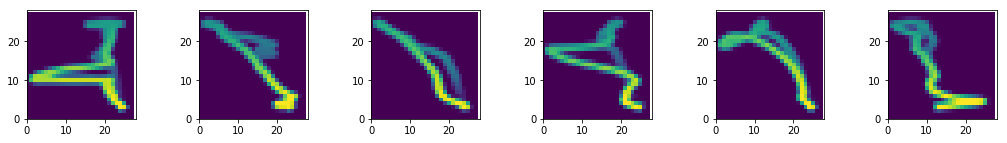

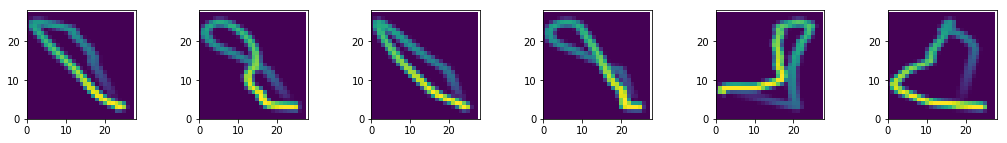

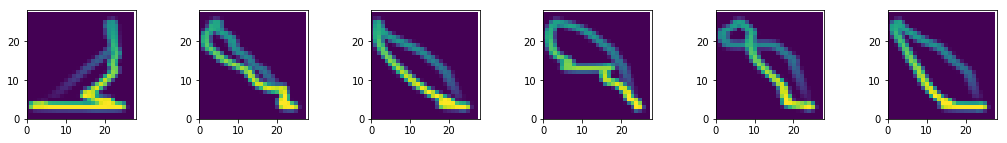

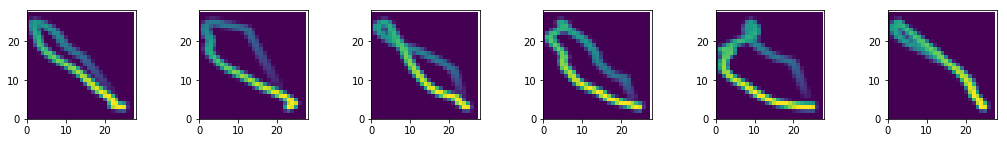

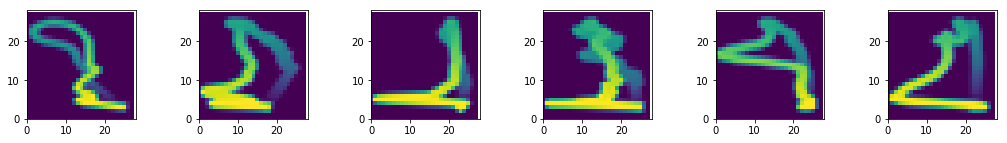

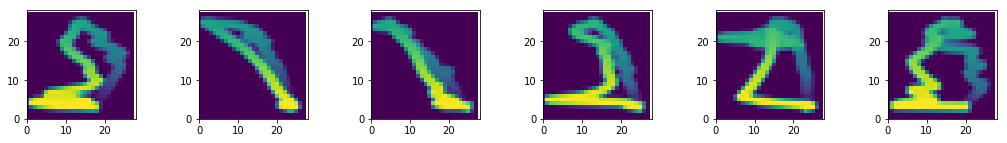

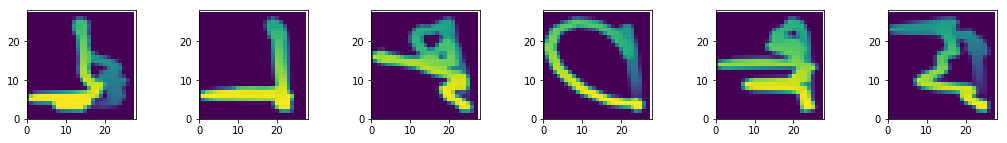

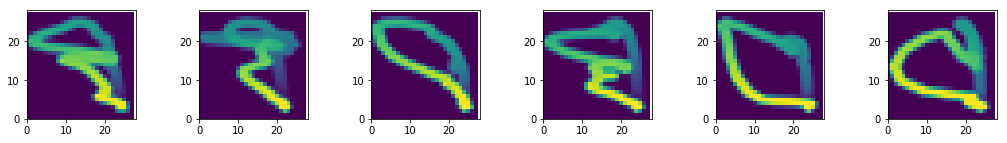

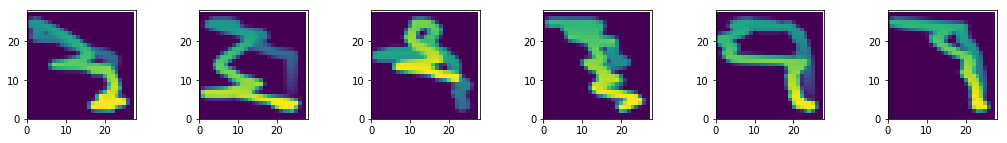

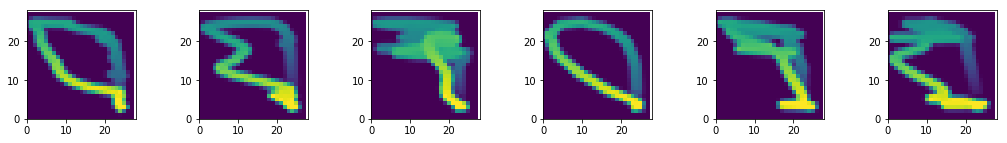

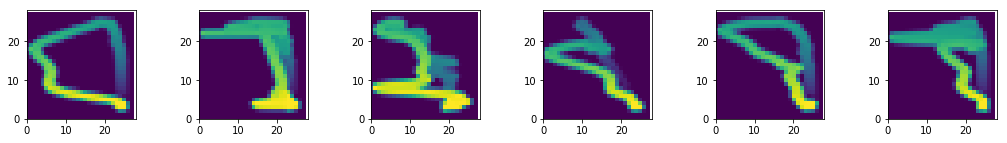

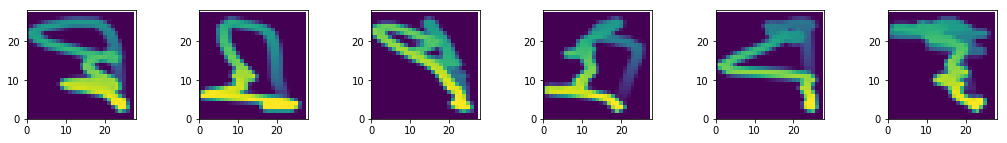

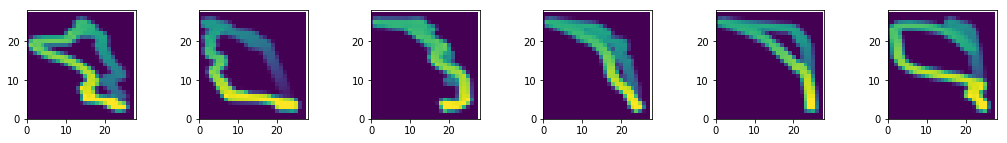

In [24]:
counter = 0
plot = []
rowsize = 6
plotCluster = 4
for label in clusterLabels:
    
    if label == plotCluster:
        plot.append(counter)
    
    if (len(plot)% rowsize ==0) and (len(plot)>0):
        displayHysteresis(dataPath,plot,rowsize)
        plt.show()
        plot = []
    counter = counter+1    

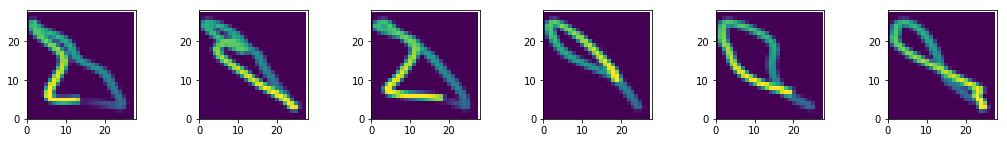

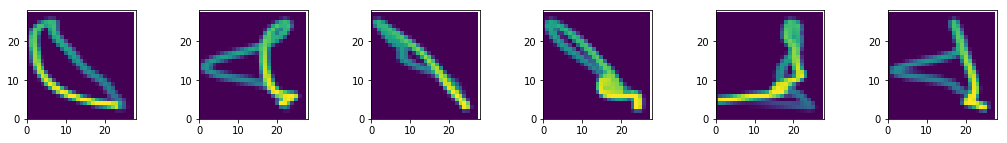

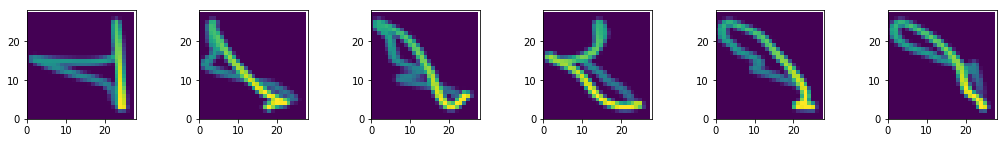

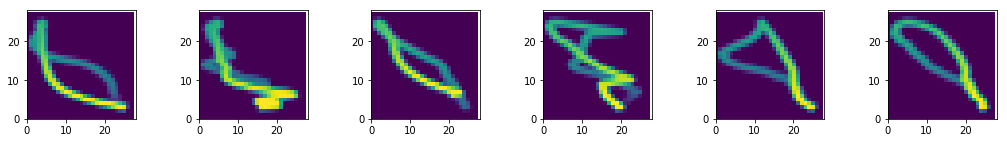

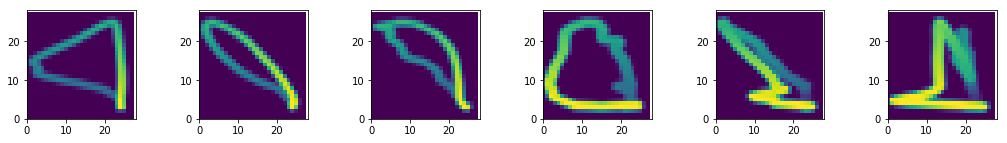

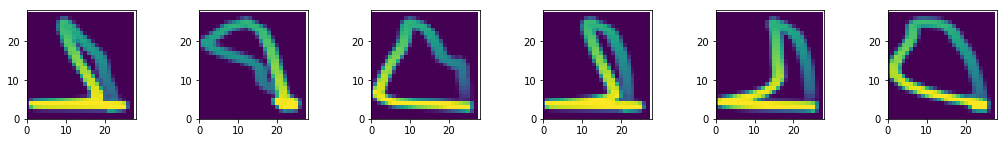

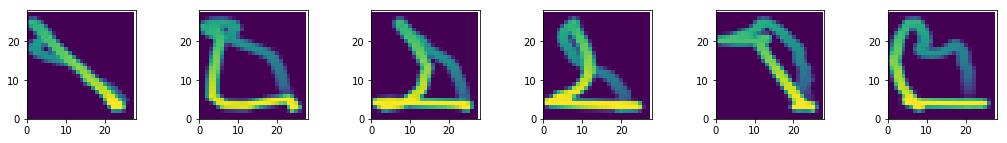

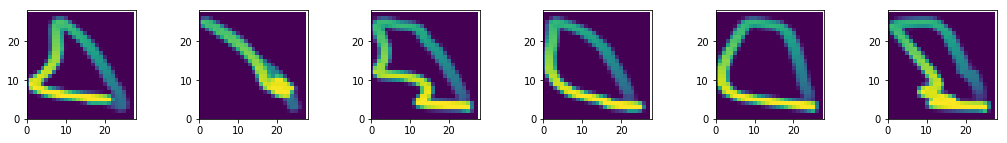

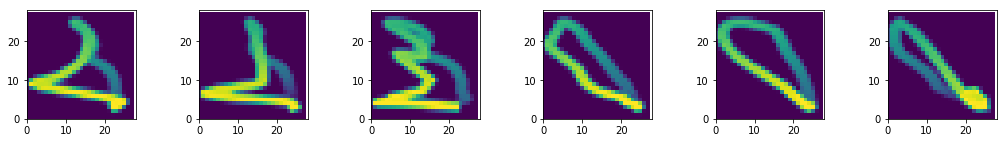

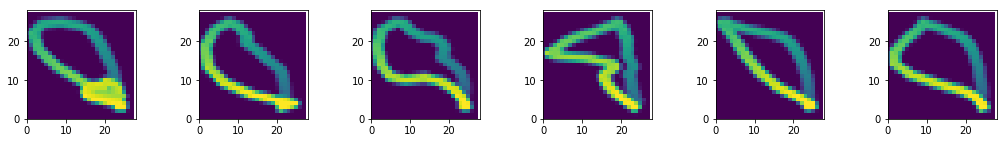

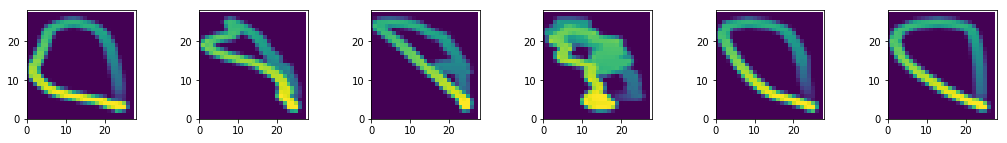

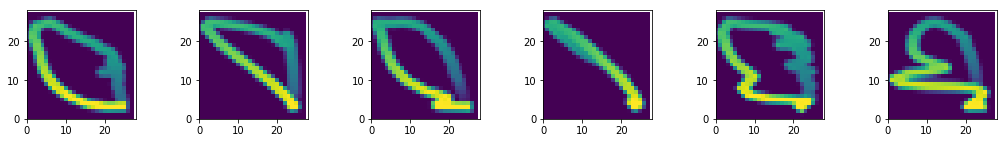

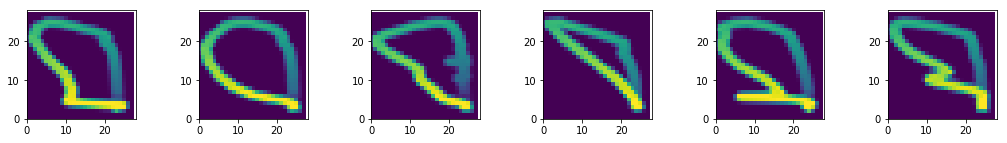

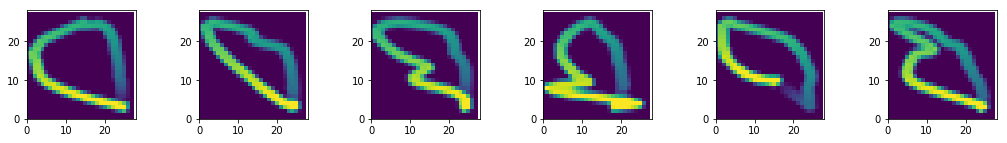

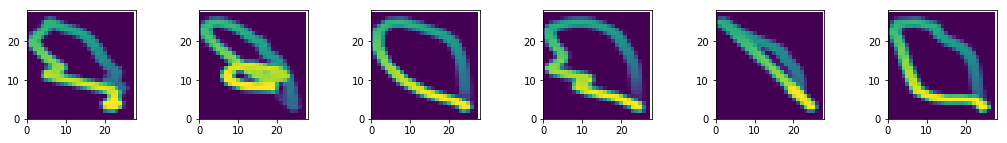

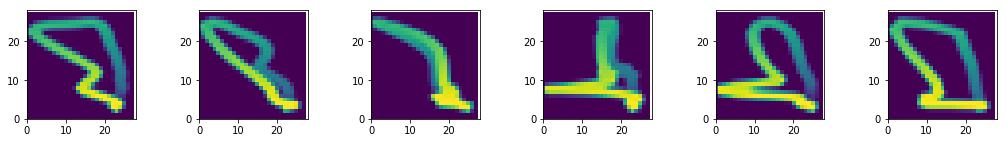

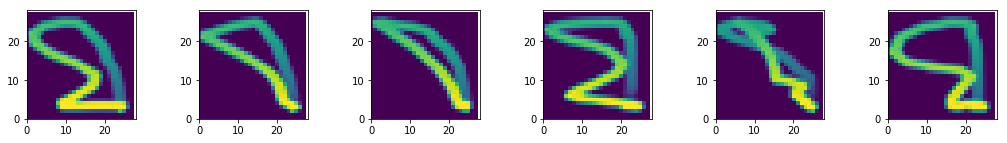

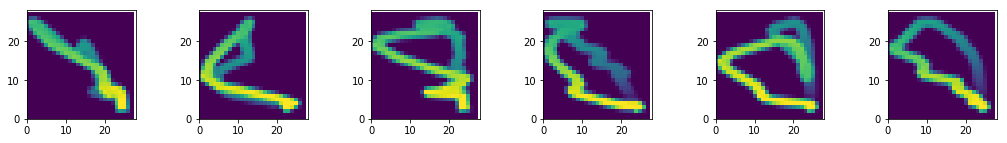

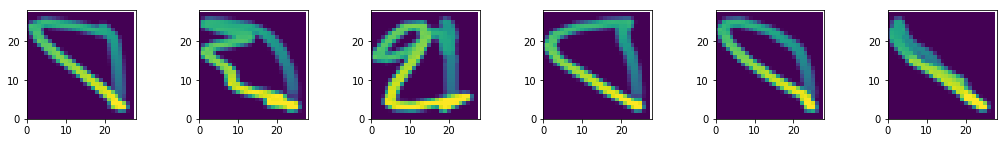

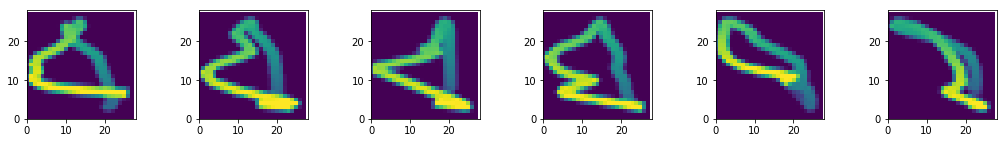

In [25]:
counter = 0
plot = []
rowsize = 6
plotCluster = 5
for label in clusterLabels:
    
    if label == plotCluster:
        plot.append(counter)
    
    if (len(plot)% rowsize ==0) and (len(plot)>0):
        displayHysteresis(dataPath,plot,rowsize)
        plt.show()
        plot = []
    counter = counter+1    

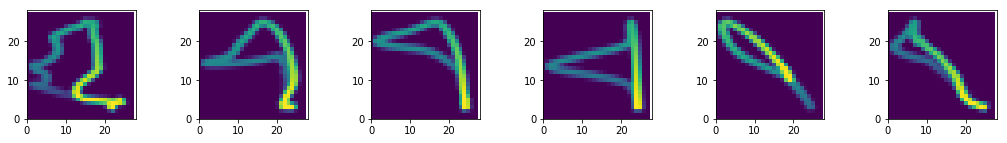

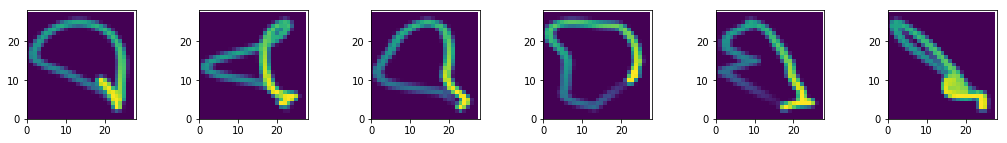

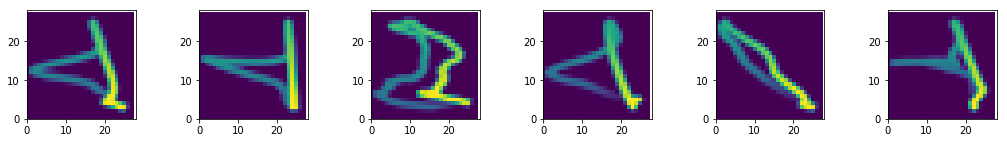

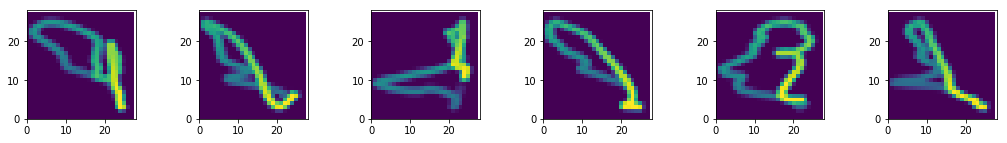

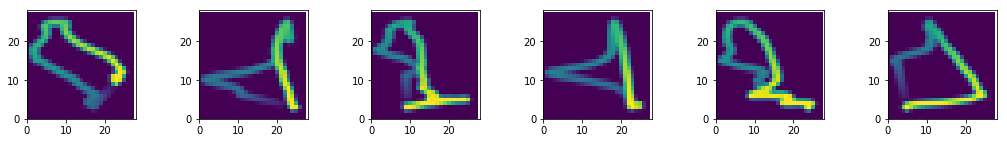

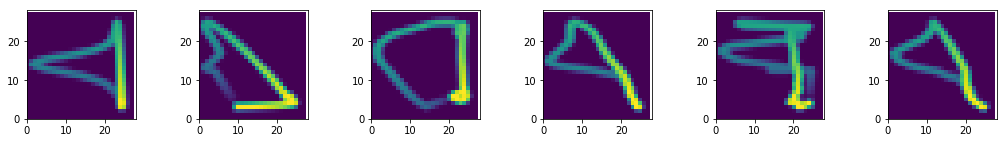

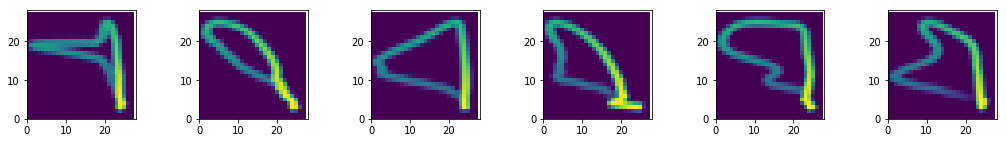

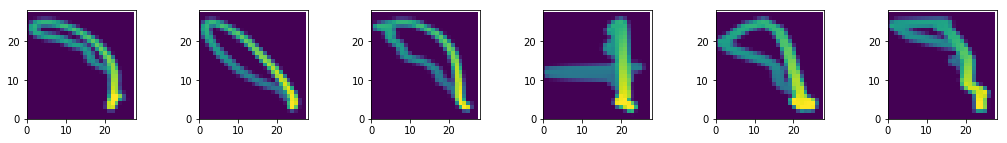

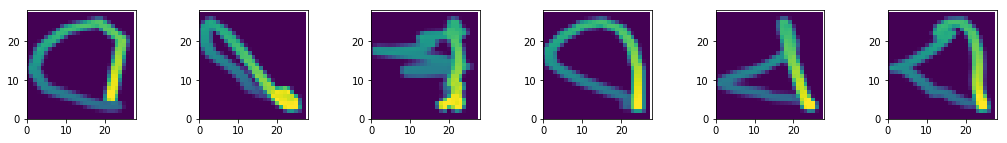

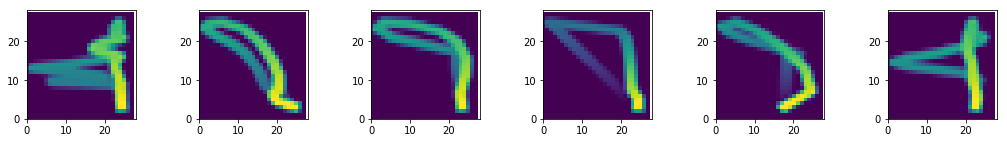

In [26]:
## just clusters from original 2d GT

counter = 0
plot = []
rowsize = 6
plotCluster = np.array([4,5,6,7,8])
plotCluster = np.array([ 9,10,11] )
for label in eventToClass:
    
    if label in plotCluster:
        plot.append(counter)
    
    if (len(plot)% rowsize ==0) and (len(plot)>0):
        displayHysteresis(dataPath,plot,rowsize)
        plt.show()
        plot = []
    counter = counter+1    

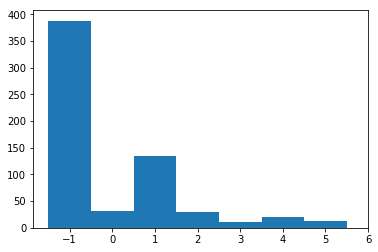

In [41]:
from sklearn.cluster import DBSCAN
fig, ax = plt.subplots(1,1)
db = DBSCAN(eps=3.4, min_samples=10).fit(preds)
d = db.labels_
bins = np.arange(d.min(), d.max()+1)
ax.hist(d, bins=bins,align='left')
align='left'
ax.set_xticks(bins)
plt.show() 

In [42]:
from collections import Counter
c = Counter(d)
c

Counter({-1: 388, 0: 31, 1: 134, 2: 29, 3: 10, 4: 21, 5: 6, 6: 7})

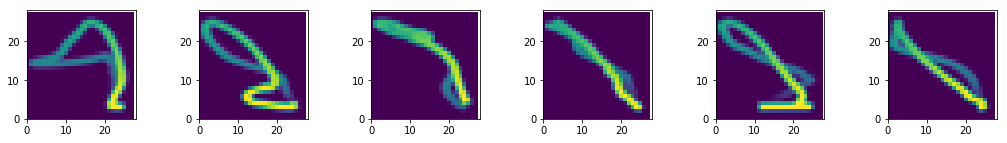

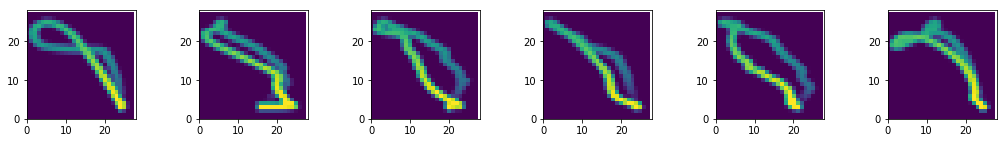

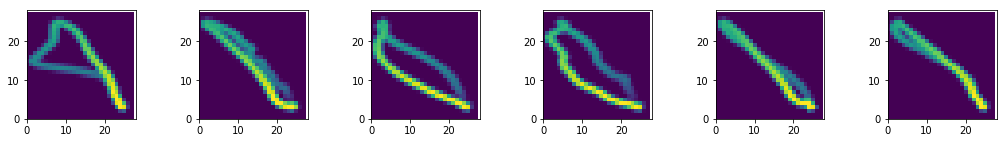

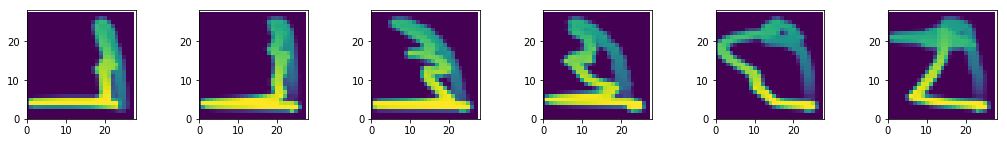

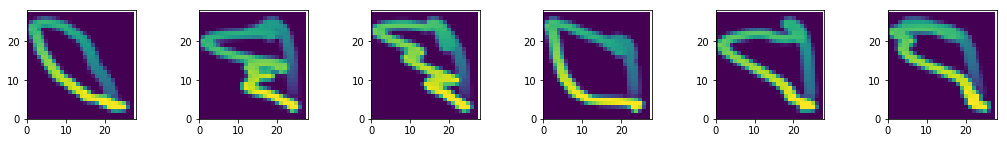

In [43]:
counter = 0
plot = []
rowsize = 6
plotCluster = 0
for label in d:
    
    if label == plotCluster:
        plot.append(counter)
    
    if (len(plot)% rowsize ==0) and (len(plot)>0):
        displayHysteresis(dataPath,plot,rowsize)
        plt.show()
        plot = []
    counter = counter+1   

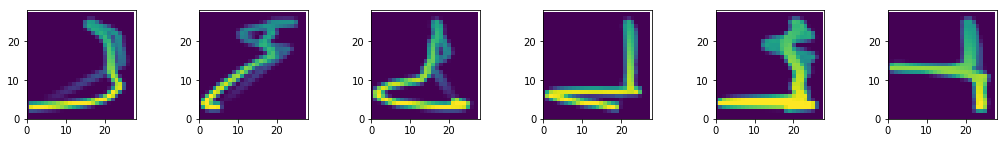

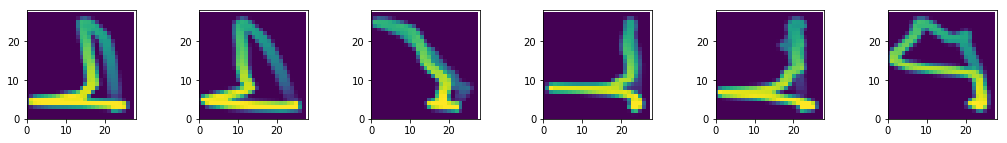

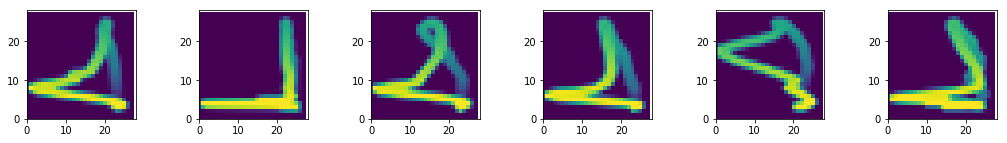

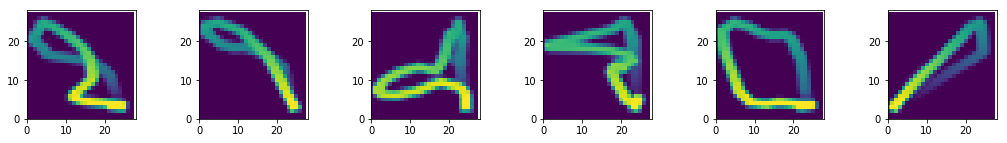

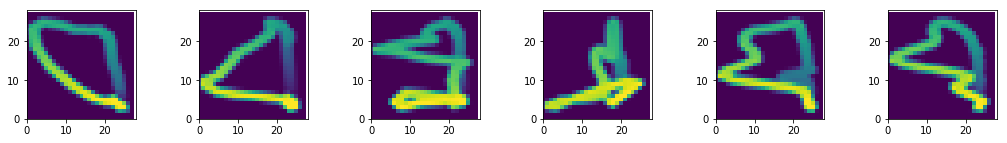

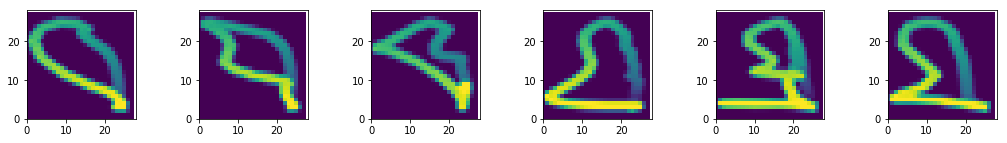

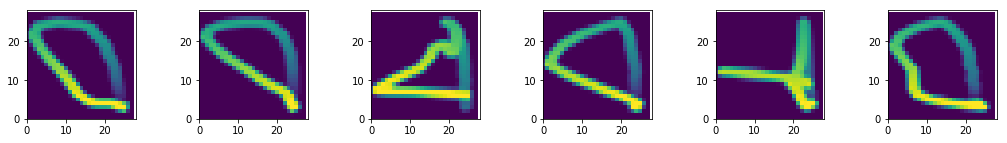

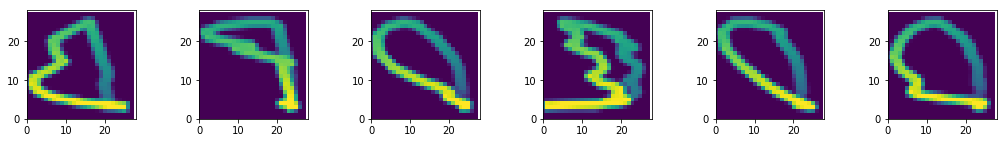

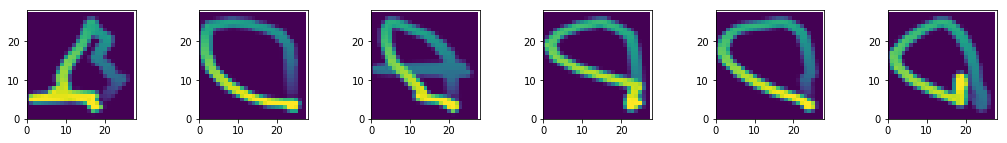

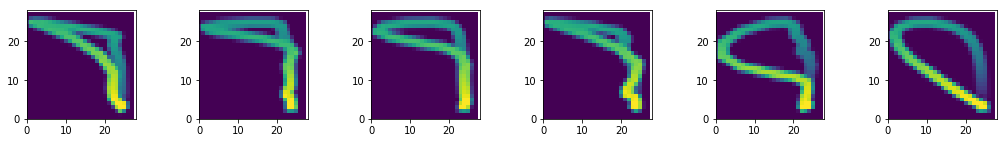

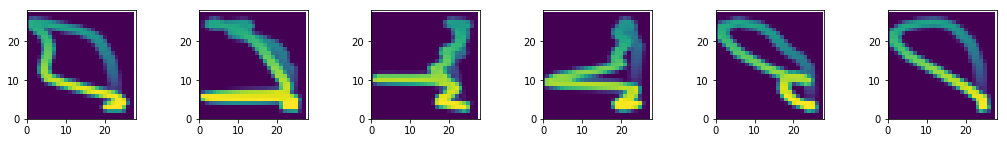

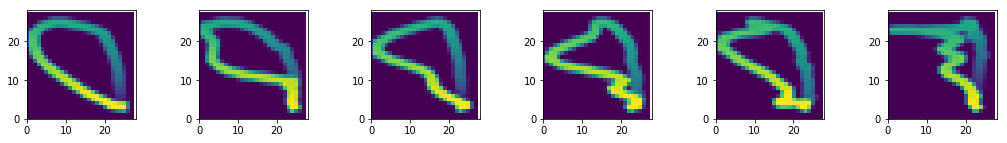

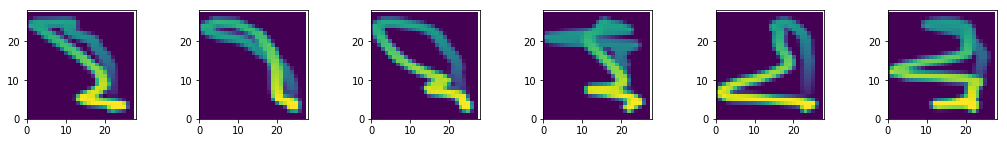

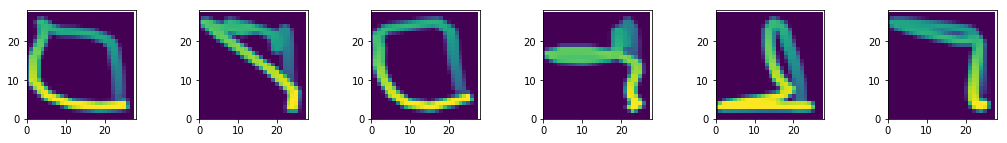

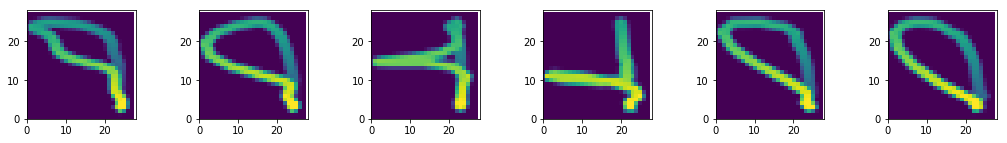

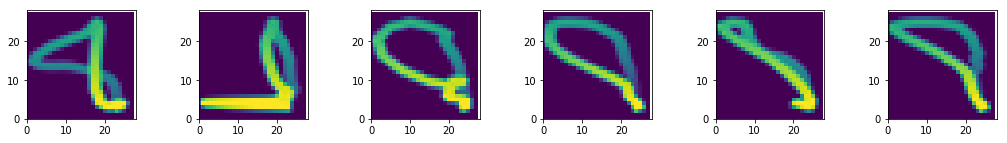

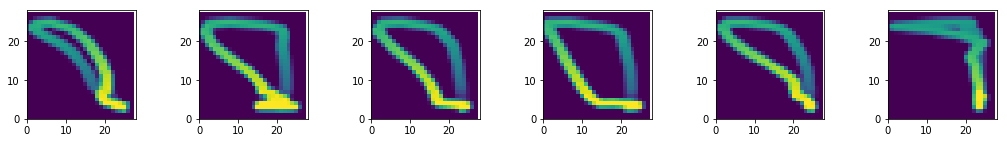

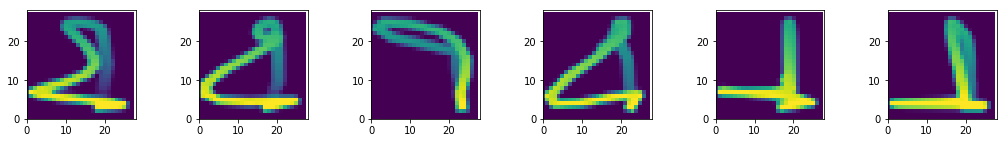

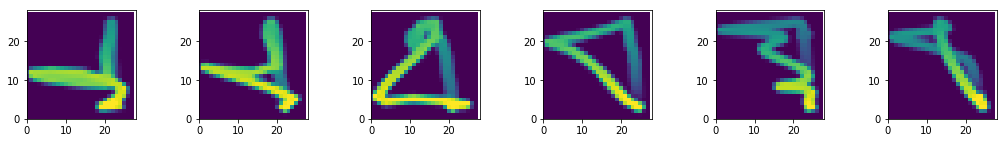

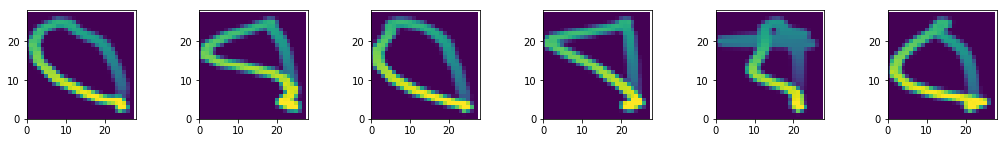

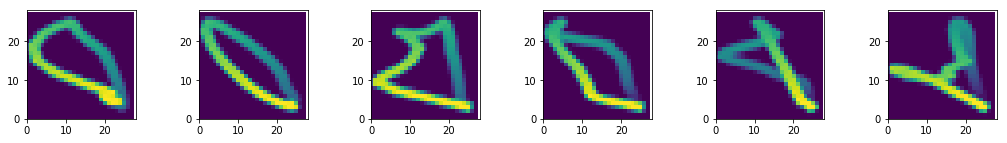

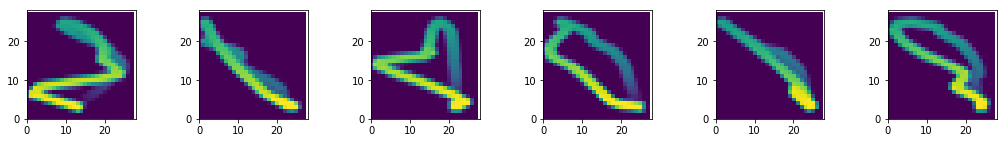

In [44]:
counter = 0
plot = []
rowsize = 6
plotCluster = 1
for label in d:
    
    if label == plotCluster:
        plot.append(counter)
    
    if (len(plot)% rowsize ==0) and (len(plot)>0):
        displayHysteresis(dataPath,plot,rowsize)
        plt.show()
        plot = []
    counter = counter+1 

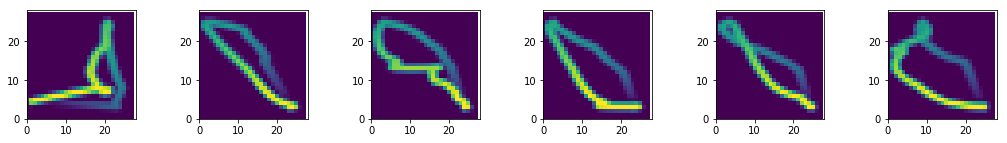

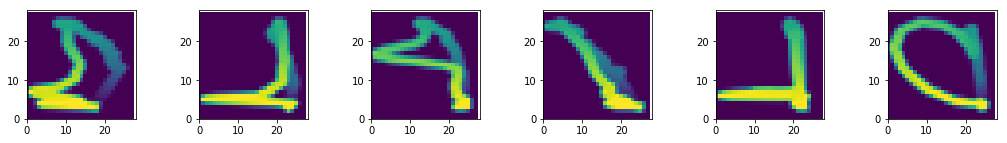

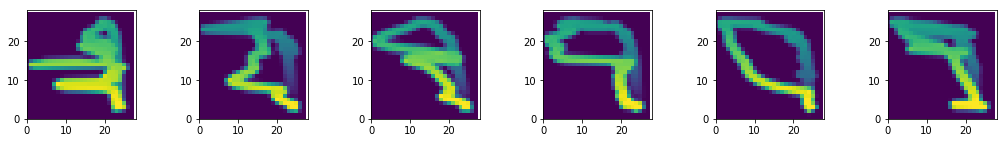

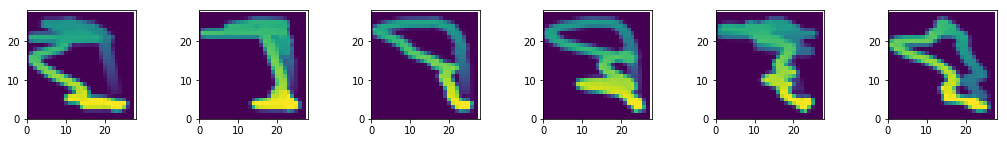

In [45]:
counter = 0
plot = []
rowsize = 6
plotCluster = 2
for label in d:
    
    if label == plotCluster:
        plot.append(counter)
    
    if (len(plot)% rowsize ==0) and (len(plot)>0):
        displayHysteresis(dataPath,plot,rowsize)
        plt.show()
        plot = []
    counter = counter+1 

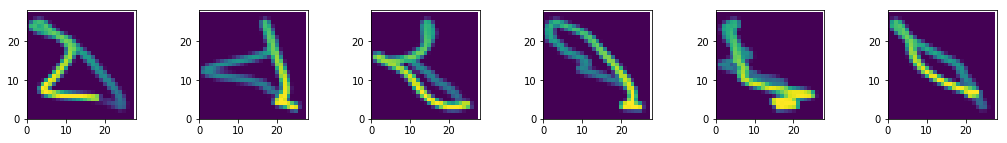

In [46]:
counter = 0
plot = []
rowsize = 6
plotCluster = 3
for label in d:
    
    if label == plotCluster:
        plot.append(counter)
    
    if (len(plot)% rowsize ==0) and (len(plot)>0):
        displayHysteresis(dataPath,plot,rowsize)
        plt.show()
        plot = []
    counter = counter+1 

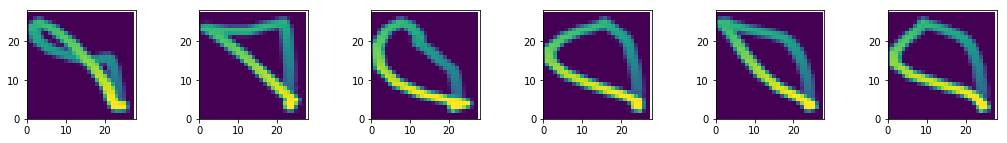

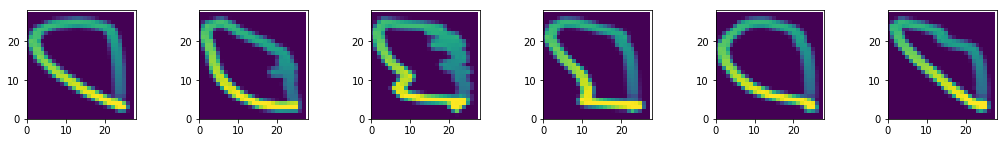

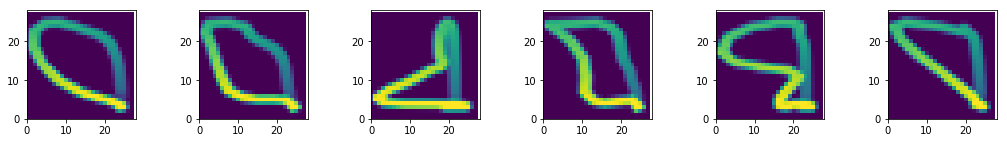

In [47]:
counter = 0
plot = []
rowsize = 6
plotCluster = 4
for label in d:
    
    if label == plotCluster:
        plot.append(counter)
    
    if (len(plot)% rowsize ==0) and (len(plot)>0):
        displayHysteresis(dataPath,plot,rowsize)
        plt.show()
        plot = []
    counter = counter+1 

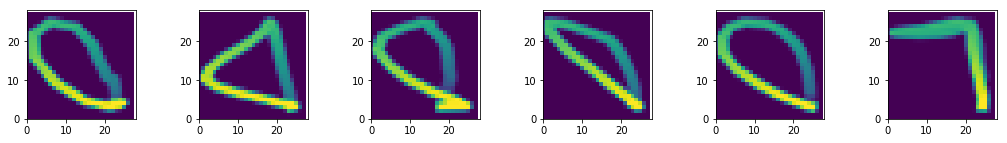

In [48]:
counter = 0
plot = []
rowsize = 6
plotCluster = 5
for label in d:
    
    if label == plotCluster:
        plot.append(counter)
    
    if (len(plot)% rowsize ==0) and (len(plot)>0):
        displayHysteresis(dataPath,plot,rowsize)
        plt.show()
        plot = []
    counter = counter+1 

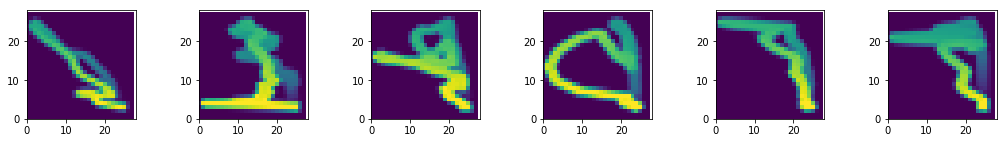

In [49]:
counter = 0
plot = []
rowsize = 6
plotCluster = 6
for label in d:
    
    if label == plotCluster:
        plot.append(counter)
    
    if (len(plot)% rowsize ==0) and (len(plot)>0):
        displayHysteresis(dataPath,plot,rowsize)
        plt.show()
        plot = []
    counter = counter+1 